In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re

import warnings
warnings.filterwarnings("ignore")

def find_clumsy_directories(root='.'):
    res = []
    for dirpath, dirnames, filenames in os.walk(root):
        for dirname in dirnames:
            if 'clumsy' in dirname.lower():
                res.append(os.path.join(dirpath, dirname))
    return res

def reset_timestamp(df):
    df['timestamp'] = df['timestamp'] - df['timestamp'][0]
    return df

def process_line(line):
    timestamp = line.split(' ')[1]
    content = line.split('  : ')[1]
#     print(content)
    pairs = content.split(',')
#     print(pairs)
    d = {}
    cpugpu = re.search("CPU4/GPU=\d+/\d+,\d+/\d+", content).group()
    cpugpu = cpugpu.split('=')[1]
    cpugpu = cpugpu.split('/')
    d['CPU Level'] = int(cpugpu[0])
    d['GPU Level'] = int(cpugpu[1].split(',')[0])
    d['CPU Frequency (MHz)'] = int(cpugpu[1].split(',')[1])
    d['GPU Frequency (MHz)'] = int(cpugpu[2])
    for x in pairs:
        tmp = x.split('=')
        if tmp[0] == 'CPU4/GPU' or len(tmp) < 2:
            continue
        if tmp[0] == 'FPS':
            d[tmp[0]] = int(tmp[1].split('/')[0])
        elif tmp[0] == 'Free':
            d[tmp[0]] = int(tmp[1][:-2])
        else:
            d[tmp[0]] = tmp[1].strip()
#     print(pairs[0].split('='))
#     d = {x.split('=')[0] : x.split('=')[1] for x in pairs}
#     print(d)
    d["timestamp"] = timestamp
#     print(d)
    return pd.DataFrame(d, index=[0])

def add_to_dataframe(df, timestamp, key, value):
    if key not in df.columns:
        df[key] = np.nan
    df.loc[timestamp, key] = value
    return df

def create_dataframe(file_path):
    df = pd.DataFrame()
    for line in open(file_path, 'r', encoding='utf-16'):
        if len(line) < 300:
            continue
        new_d = process_line(line)
        df = df.append(new_d)

#     df.index.name = 'timestamp'
#     df = df.reset_index()

    df['altered_bandwidth'] = file_path.split('\\')[1].split('-')[1] == 'bandwidth'
    df['altered_dropchance'] = file_path.split('\\')[1].split('-')[1] == 'dropchance'
    df['bandwidth'] = int(file_path.split('\\')[1].split('-')[2][:-4]) if file_path.split('\\')[1].split('-')[1] == 'bandwidth' else 999999
    df['dropchance'] = float(file_path.split('\\')[1].split('-')[2]) if file_path.split('\\')[1].split('-')[1] == 'dropchance' else 0
    df['device'] = file_path.split('\\')[2]
    df['app'] = file_path.split('\\')[3].strip('-W')
    df['app_details'] = file_path.split('\\')[4]
    df['is_record'] = 'record' in file_path.split('\\')[5]
    df['is_wireless'] = '-W' in file_path.split('\\')[3]
    df['repetition'] = file_path.split('\\')[5].strip('record') if 'record' in file_path.split('\\')[5] else file_path.split('\\')[5].strip('replay')

    df.to_csv(f'.\\{file_path.strip(".log")}.csv', index=False)

    return df

clumsy_dirs = find_clumsy_directories()

df_aggregated = pd.DataFrame()

for clumsy in clumsy_dirs:
    for root, dirs, files in os.walk(clumsy, topdown=False):
        for name in files:
            if name == 'logcat_VrApi.log':
                print(os.path.join(root, name))
                df_aggregated = pd.concat([df_aggregated, create_dataframe(os.path.join(root, name))]) 
                
print(df_aggregated)
df = df_aggregated
df

.\clumsy-bandwidth-100Mbps\Quest-2\BeatSaber\PopStars-Medium\record1\logcat_VrApi.log
.\clumsy-bandwidth-100Mbps\Quest-2\BeatSaber\PopStars-Medium\replay1.0\logcat_VrApi.log
.\clumsy-bandwidth-100Mbps\Quest-2\BeatSaber\PopStars-Medium\replay1.1\logcat_VrApi.log
.\clumsy-bandwidth-100Mbps\Quest-2\BeatSaber\PopStars-Medium\replay1.2\logcat_VrApi.log
.\clumsy-bandwidth-100Mbps\Quest-Pro\BeatSaber\PopStars-Medium\record1\logcat_VrApi.log
.\clumsy-bandwidth-100Mbps\Quest-Pro\BeatSaber\PopStars-Medium\replay1.0\logcat_VrApi.log
.\clumsy-bandwidth-100Mbps\Quest-Pro\BeatSaber\PopStars-Medium\replay1.1\logcat_VrApi.log
.\clumsy-bandwidth-100Mbps\Quest-Pro\BeatSaber\PopStars-Medium\replay1.2\logcat_VrApi.log
.\clumsy-bandwidth-30Mbps\Quest-2\BeatSaber\PopStars-Medium\record1\logcat_VrApi.log
.\clumsy-bandwidth-30Mbps\Quest-2\BeatSaber\PopStars-Medium\replay1.0\logcat_VrApi.log
.\clumsy-bandwidth-30Mbps\Quest-2\BeatSaber\PopStars-Medium\replay1.1\logcat_VrApi.log
.\clumsy-bandwidth-30Mbps\Quest-2

,CPU Level,GPU Level,CPU Frequency (MHz),GPU Frequency (MHz),FPS,Prd,Tear,Early,Stale,Stale2/5/10/max,...,altered_bandwidth,altered_dropchance,bandwidth,dropchance,device,app,app_details,is_record,is_wireless,repetition
0,5,4,1478,525,73,0ms,0,0,0,0/0/0/0,...,True,False,100,0.00,Quest-2,BeatSaber,PopStars-Medium,True,False,1
0,5,4,1478,525,73,0ms,0,0,0,0/0/0/0,...,True,False,100,0.00,Quest-2,BeatSaber,PopStars-Medium,True,False,1
0,5,4,1478,525,72,0ms,0,0,0,0/0/0/0,...,True,False,100,0.00,Quest-2,BeatSaber,PopStars-Medium,True,False,1
0,5,4,1478,525,73,0ms,0,0,1,0/0/0/1,...,True,False,100,0.00,Quest-2,BeatSaber,PopStars-Medium,True,False,1
0,5,4,1478,525,73,0ms,0,0,0,0/0/0/0,...,True,False,100,0.00,Quest-2,BeatSaber,PopStars-Medium,True,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,4,4,1478,525,21,0ms,0,34,52,21/0/0/3,...,False,True,999999,0.05,Quest-Pro,BeatSaber,PopStars-Medium,False,False,1.2
0,4,4,1478,525,21,0ms,0,33,53,20/0/0/3,...,False,True,999999,0.05,Quest-Pro,BeatSaber,PopStars-Medium,False,False,1.2
0,4,4,1478,525,21,0ms,0,32,52,21/0/0/3,...,False,True,999999,0.05,Quest-Pro,BeatSaber,PopStars-Medium,False,False,1.2
0,4,4,1478,525,21,0ms,0,34,52,21/0/0/3,...,False,True,999999,0.05,Quest-Pro,BeatSaber,PopStars-Medium,False,False,1.2


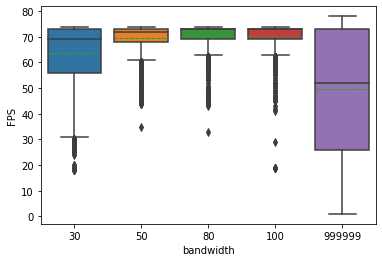

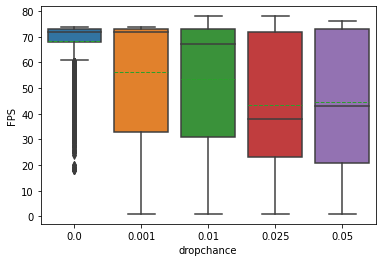

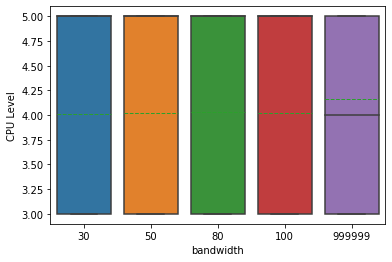

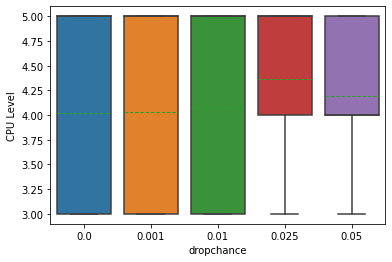

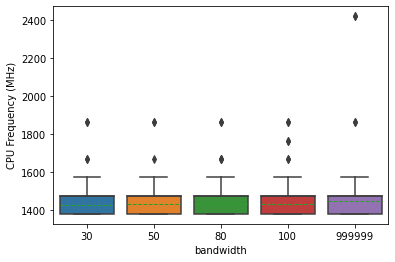

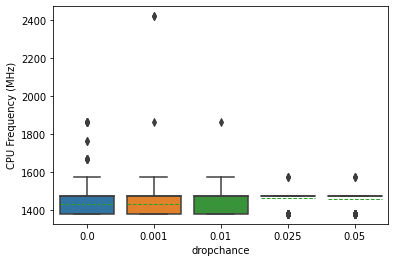

In [7]:
sns.boxplot(data=df, x='bandwidth', y='FPS', showmeans=True, meanline=True)
plt.show()

sns.boxplot(data=df, x='dropchance', y='FPS', showmeans=True, meanline=True)
plt.show()

sns.boxplot(data=df, x='bandwidth', y='CPU Level', showmeans=True, meanline=True)
plt.show()

sns.boxplot(data=df, x='dropchance', y='CPU Level', showmeans=True, meanline=True)
plt.show()

sns.boxplot(data=df, x='bandwidth', y='CPU Frequency (MHz)', showmeans=True, meanline=True)
plt.show()

sns.boxplot(data=df, x='dropchance', y='CPU Frequency (MHz)', showmeans=True, meanline=True)
plt.show()